# Magic functions

You can enable magic functions by loading ``pandas_td.ipython``:

In [1]:
%load_ext pandas_td.ipython

It can be loaded automatically by the following configuration in "~/.ipython/profile_default/ipython_config.py":

In [ ]:
c = get_config()

c.InteractiveShellApp.extensions = [
    'pandas_td.ipython',
]

After loading the extension, type "%td" and press TAB to list magic functions:

![Image](http://i.gyazo.com/ff9d7c5de1b16a21236fa7fb5d47d5a4.png)

# List functions

``%td_databases`` returns the list of databases:

In [2]:
%td_databases

,name,count,permission,created_at,updated_at
0,sample_datasets,8812278,query_only,2014-10-04 01:13:11+00:00,2015-01-09 01:07:14+00:00
1,tutorial,19,full_access,2015-05-27 13:12:43+00:00,2015-05-27 13:12:43+00:00


``%td_tables`` returns the list of tables:

In [3]:
%td_tables sample

,db_name,name,count,estimated_storage_size,last_log_timestamp,created_at
0,sample_datasets,www_access,5000,0,2014-10-04 01:13:15+00:00,2014-10-04 01:13:12+00:00
1,sample_datasets,nasdaq,8807278,168205061,1970-01-01 00:00:00+00:00,2014-10-08 02:57:38+00:00


``%td_jobs`` returns the list of recently executed jobs:

In [4]:
%td_jobs

,status,job_id,type,start_at,query
0,success,28870939,presto,2015-07-10 19:37:05+00:00,"-- read_td_table('nasdaq')\nSELECT time, symbo..."
1,success,28870917,presto,2015-07-10 19:36:05+00:00,"-- read_td_table('nasdaq')\nSELECT time, symbo..."
2,success,28870902,presto,2015-07-10 19:35:40+00:00,-- read_td_table('www_access')\nSELECT *\nFROM...


# Use database

``%td_use`` is a special function that has side effects.  First, it pushes table names into the current namespace:

In [5]:
%td_use sample_datasets

INFO: import nasdaq
INFO: import www_access


By printing a table name, you can describe column names:

In [6]:
nasdaq

,field,type,alias
0,symbol,string,
1,open,double,
2,volume,long,
3,high,double,
4,low,double,
5,close,double,


Tab completion is also supported:

![Tab completion](http://i.gyazo.com/fde882bc1bd665ba080cbd72222e27cb.png)

As the second effect of ``%td_use``, it declares "default database", which is used when you write queries without databases.

# Query functions

``%%td_hive``, ``%%td_pig``, and ``%%td_presto`` are cell magic functions that run queries:

In [7]:
%%td_presto
select count(1) cnt
from nasdaq

,cnt
0,8807278


The result of the query can be stored in a variable by ``-o``:

In [8]:
%%td_presto -o df
select count(1) cnt
from nasdaq

In [9]:
df

,cnt
0,8807278


Or you can save the result into a file by ``-O``:

In [10]:
%%td_presto -O './output.csv'
select count(1) cnt
from nasdaq

INFO: saved to './output.csv'


Python-style variable substition is supported:

In [11]:
start = '2010-01-01'
end = '2011-01-01'

In [12]:
%%td_presto
select count(1) cnt
from nasdaq
where td_time_range(time, '{start}', '{end}')

,cnt
0,503399


You can preview the actual query by ``--dry-run`` (or ``-n``):

In [13]:
%%td_presto -n
select count(1) cnt
from nasdaq
where td_time_range(time, '{start}', '{end}')

## Time-series index

With magic functions, "time" column is converted into time-series index automatically.  You can use ``td_date_trunc()`` or ``td_time_format()`` in combination with ``GROUP BY`` for aggregation: 

In [14]:
%%td_presto
select
    -- Time-series index (yearly)
    td_date_trunc('year', time) time,

    -- Same as above
    -- td_time_format(time, 'yyyy-01-01') time,

    count(1) cnt
from
    nasdaq
group by
    1
limit
    3

,cnt
time,
2014-01-01,488038
2013-01-01,604731
2012-01-01,568353


## Plotting

``--plot`` is a convenient option for plotting.  The first column represents x-axis.  Other columns represent y-axis:

In [15]:
%matplotlib inline

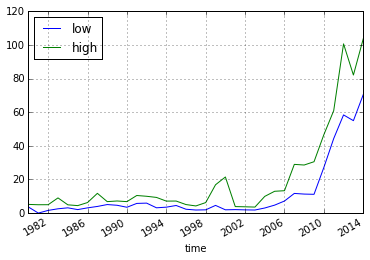

In [16]:
%%td_presto --plot
select
    -- x-axis
    td_date_trunc('year', time) time,

    -- y-axis
    min(low) low,
    max(high) high
from
    nasdaq
where
    symbol = 'AAPL'
group by
    1

If the result contains non-numeric columns, or column names ending with "_id", they act as "dimensions" in terms of OLAP:

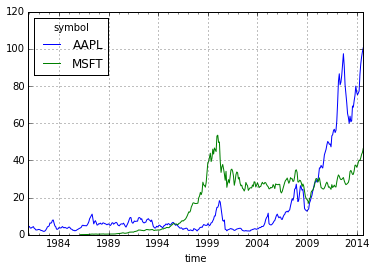

In [17]:
%%td_presto --plot
select
    -- x-axis
    td_date_trunc('month', time) time,

    -- dimensions
    symbol,

    -- measures (y-axis)
    avg(close) close 
from
    nasdaq
where
    symbol in ('AAPL', 'MSFT')
group by
    1, 2

## Pivit tables

``--pivot`` creates a pivot table from the result of query.  Like ``--plot``, the first column represents index and other non-numeric columns represents new columns:

In [18]:
%%td_presto --pivot
select
    td_date_trunc('year', time) time,
    symbol,
    avg(close) close 
from
    nasdaq
where
    td_time_range(time, '2010', '2015')
    and symbol like 'AA%'
group by
    1, 2

symbol,AAIT,AAL,AAME,AAOI,AAON,AAPL,AAVL,AAWW,AAXJ
time,,,,,,,,,
2010-01-01,NaN,NaN,1.533376,NaN,6.969612,37.134102,NaN,50.654775,57.195677
2011-01-01,NaN,NaN,2.011771,NaN,8.949413,52.000335,NaN,51.993968,57.992659
2012-01-01,27.083288,NaN,2.702549,NaN,8.721841,82.292882,NaN,46.915226,55.078226
2013-01-01,28.865318,25.754375,3.718914,12.677075,14.904996,67.518991,NaN,43.477718,58.670437
2014-01-01,33.147182,34.268635,3.845645,20.009516,19.857238,86.402960,29.485122,35.345806,61.125349


## Verbose output

By passing ``-v`` (``--verbose``) option, you can print pseudo Python code that was executed by the magic function.

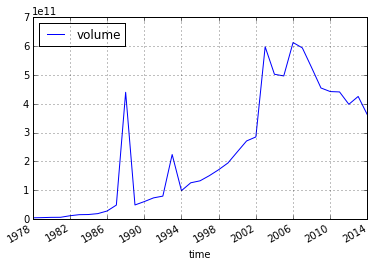

In [19]:
%%td_presto -v --plot
select
    td_date_trunc('year', time) time,
    sum(volume) volume
from
    nasdaq
group by
    1